In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

In [53]:
df = pd.read_csv("raw_data/fake_job_postings.csv")
df.shape

(17880, 18)

In [54]:
df.head(5)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [55]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [57]:
#identify missing data in individual columns
df.isna().sum()/len(df)

job_id                 0.000000
title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000056
requirements           0.150783
benefits               0.403356
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64

##### There are a lot of missing data. But description is available for 99% of the jobs. For NLP task we can focus on description and probably not worry about other field. But it would be good to see the correlation of being fraudulent to these missing  variable. i.e. if department is missing if there is a higher chance that it is fraudulent.

- Department is missing for 64% of the jobs.
- Salary range is unavailable for 84% of the jobs
- benefits missing for 40% of the jobs.
- Required experience missing for 40%
- Required education missing for 45%


In [58]:
for column in ["department","salary_range"]:
    df[f'is_missing_{column}'] = df[column].isna() | (df[column].str.strip() == '')
    contingency = pd.crosstab(df['fraudulent'], df[f'is_missing_{column}'])
    print(contingency)
    print("")


is_missing_department  False  True 
fraudulent                         
0                       5992  11022
1                        335    531

is_missing_salary_range  False  True 
fraudulent                           
0                         2645  14369
1                          223    643



There is no evident reasoning to believe missing values in department or salary range indicate if it is a fraudulent job description.
Let's look at the number of unique values in each column.

In [59]:
df.nunique()

job_id                     17880
title                      11231
location                    3105
department                  1337
salary_range                 874
company_profile             1709
description                14801
requirements               11967
benefits                    6204
telecommuting                  2
has_company_logo               2
has_questions                  2
employment_type                5
required_experience            7
required_education            13
industry                     131
function                      37
fraudulent                     2
is_missing_department          2
is_missing_salary_range        2
dtype: int64

Let's look at the distribution of fraudulent vs non-fraudulent to see if there is a class imbalance problem.

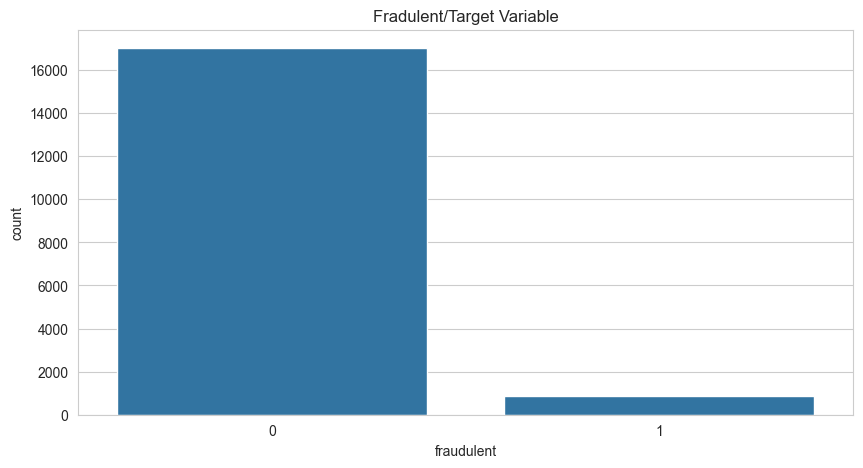

In [60]:
plt.figure(figsize = (10,5))
sns.countplot(x = df.fraudulent, data = df)
plt.title('Fradulent/Target Variable')
plt.show()

Note: Data is highly imbalanced.

Let's have a look at the different employment opportunities by experience, type and education.

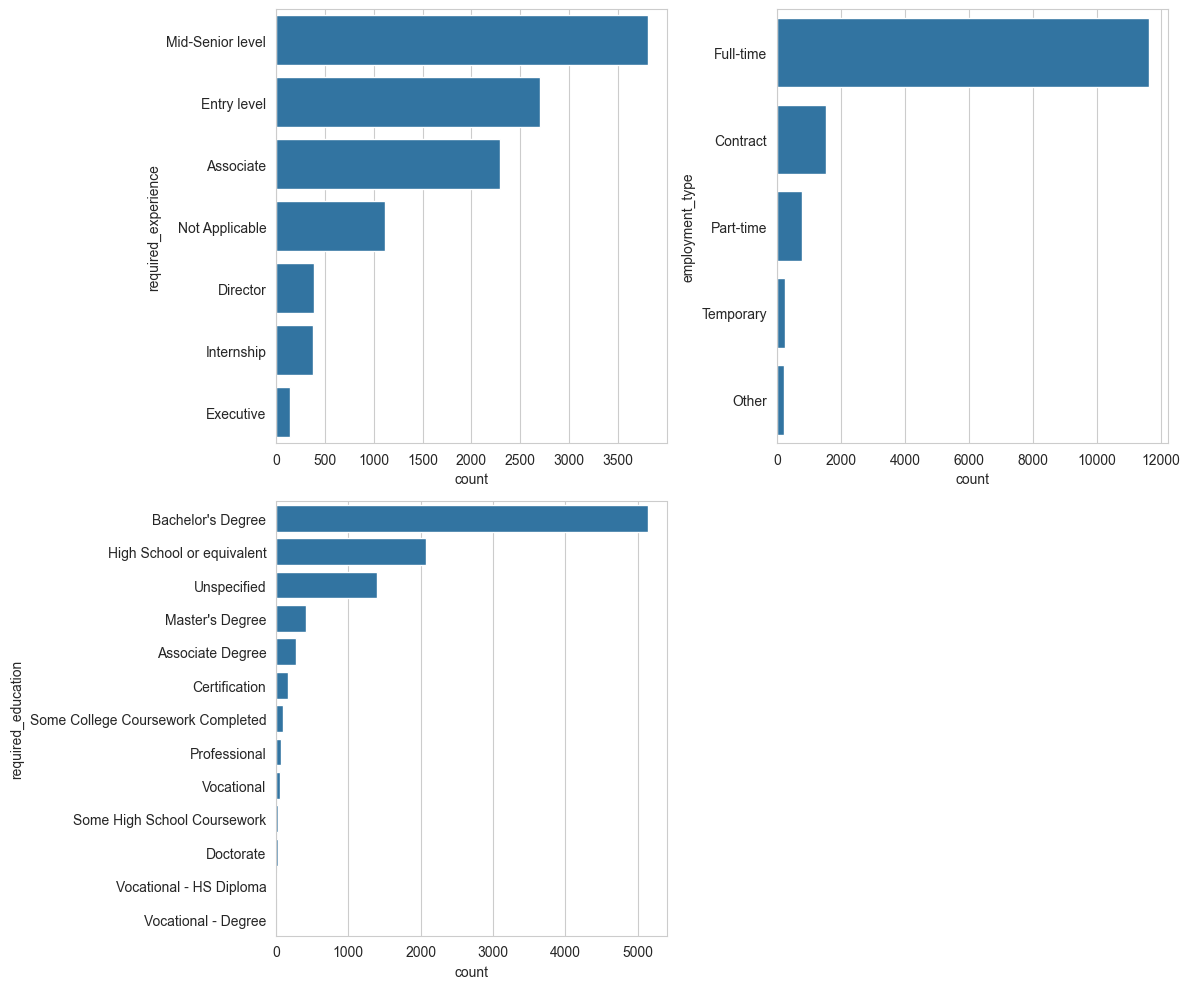

In [61]:
sns.set_style('whitegrid')
cols_to_plot = ["required_experience","employment_type","required_education"]
plt.figure(figsize = (12,10))
for i, col in enumerate(cols_to_plot):
    plt.subplot(2,2,i+1)
    sns.countplot(data = df, y = col, order = df[col].value_counts().index)
plt.tight_layout()
plt.show()

It would be interesting to see what industry/business function hires the most. But there are 131 and 37 unique values for these fields respectively. So, let us only look at the top 10.


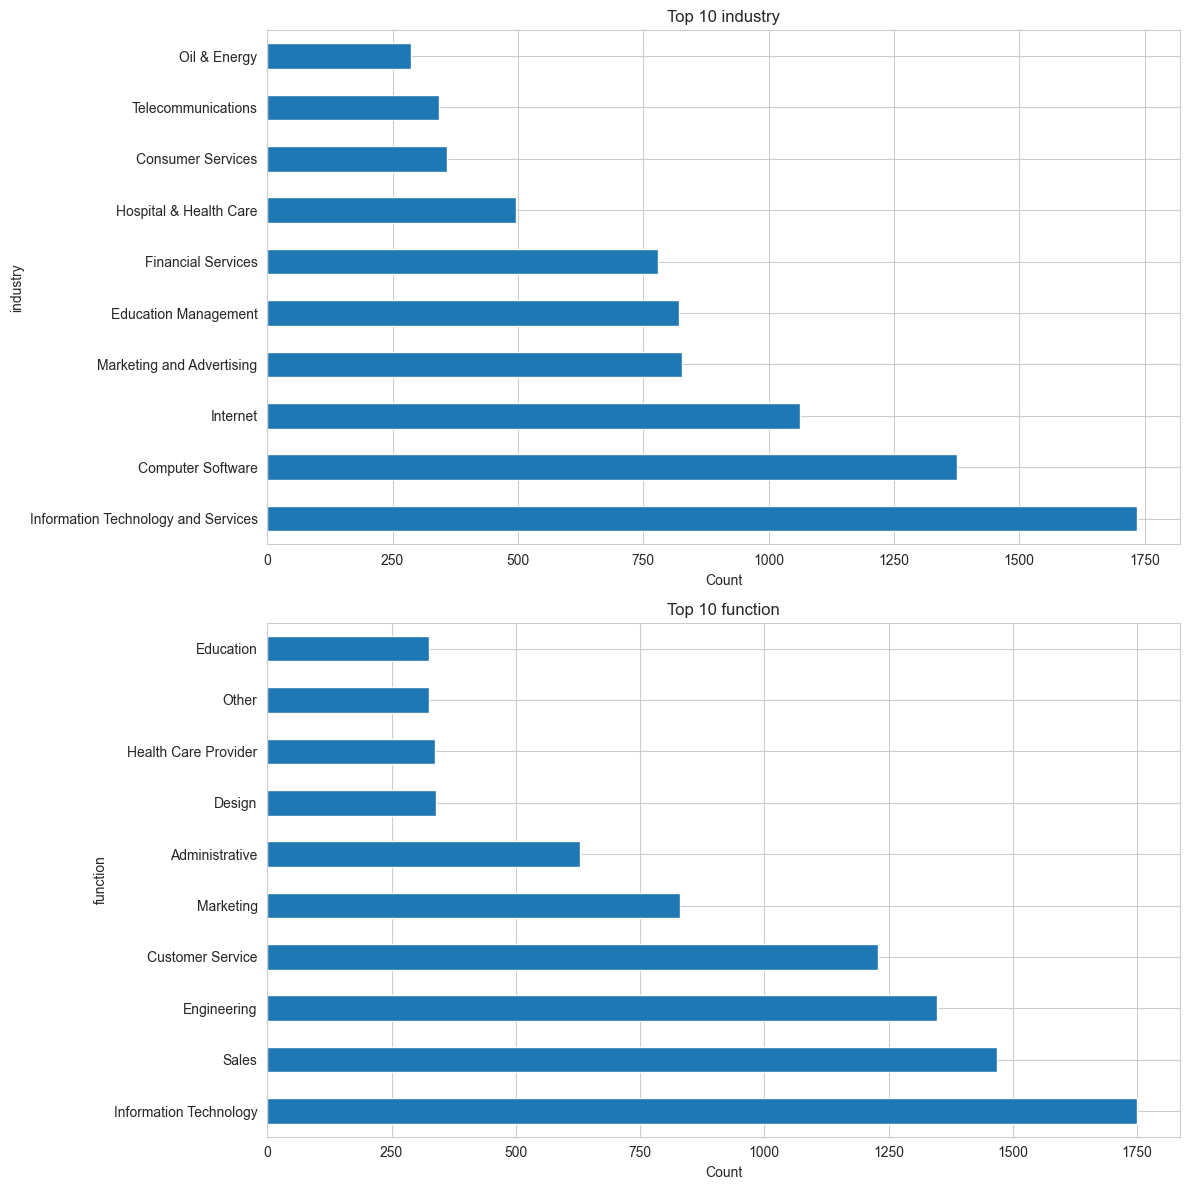

In [62]:
plt.figure(figsize = (12,12))
cols_to_plot = ["industry","function"]
for i, col in enumerate(cols_to_plot):
    data = df[col].value_counts()[:10]
    plt.subplot(2,1,i+1)
    data.plot(kind = 'barh')
    plt.title(f'Top 10 {col}')
    plt.xlabel('Count')
plt.tight_layout()
plt.show()

Conclusions:
- Most of the jobs are in IT related and most companies want mid level roles compared to others -  as one would expect.
- Minimum education requirement is a bachelor's degree for most roles, after that there is a huge market for people with only high school degrees. BOth white collar and blue collar jobs are in demand it seems.

Since, the categorical features have few nan values let's replace it with the mode  or most frequent value.  With the emergence of LLM we can even use LLM to identify each from description and company profile. But let's stick to simple solutions for now.

In [63]:
categorical_cols = ['employment_type','required_experience','required_education','industry','function']
df_copy = df.copy()
for col in categorical_cols:
    df_copy[col] = df_copy[col].fillna(df_copy[col].mode()[0])


    This is an NLP task and we will focus on description and requirements column which has natural language and so let's create a word cloud and see most occuring words.

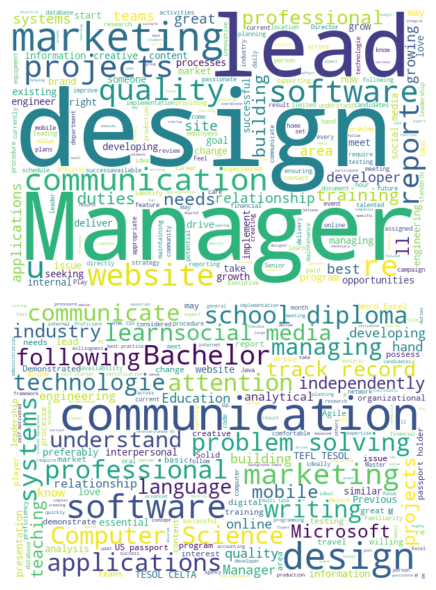

In [64]:
natural_language_cols = ["description","requirements"]
plt.figure(figsize = (8,6))
custom_stopwords = set(STOPWORDS).union({
    'job', 'role', 'position', 'description', 'responsibilities',
    'requirements', 'required', 'preferred', 'qualifications', 'responsible',
    'opportunity', 'will', 'must', 'should', 'can', 'able', 'ensure', 'provide',
    'support', 'manage', 'help', 'create', 'maintain', 'develop', 'perform',
    'make', 'team', 'company', 'organization', 'client', 'customer', 'service',
    'people', 'partner', 'employee', 'staff', 'users', 'ability', 'skills',
    'experience', 'knowledge', 'understanding',  'detail',
    'strong', 'excellent', 'verbal', 'written', 'year', 'years', 'working',
    'full', 'time', 'based', 'office', 'within', 'looking', 'join', 'well',
    'work', 'apply', 'needed', 'including', 'etc', 'want', 'passion',
    'offer', 'world', 'high', 'standard', 'environment','minimum','amp','good','need',
    'include','performance','project', 'product', 'management', 'development',
    'business', 'system', 'application', 'solutions', 'operations',
    'plan', 'tools', 'tasks', 'customer', 'clients', 'sales',
    'build', 'team', 'data', 'technical', 'plus', 'related', 'equivalent', 'including', 'degree',
    'minimum', 'level', 'english', 'university', 'fast', 'paced',
    'least', 'assist', 'help', 'use', 'working',
    'order', 'perform', 'services', 'closely','using', 'amp', 'required', 'preferred', 'based', 'high',
    'effectively', 'support','key','part','nan','field','new','process','member','search',
    'candidate', 'members', 'individual', 'learner', 'seek', 'account','web', 'tools', 'platform','free','products', 'customers','day', 'one',
     'relevant', 'proven','S','technology'

})
for i,col in enumerate(natural_language_cols):
    text = " ".join(str(x) for x in df[col])
    plt.subplot(2,1,i+1)
    wordcloud_image = WordCloud(width=600, height=400,stopwords=custom_stopwords, background_color='white').generate(text)
    plt.imshow(wordcloud_image, interpolation='bilinear')
    plt.axis('off')
plt.tight_layout()
plt.show()


It seems like the most sought after talent is communication skills and most of the roles are for managers or leads, which align with the our initial analysis that majority are postings for mid-level roles.

In [65]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64